## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



In [ ]:
pip install tensorflow==2.12.0

## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from google.colab import drive

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout



**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IA embarquee/data/ai4i2020.csv")
print(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

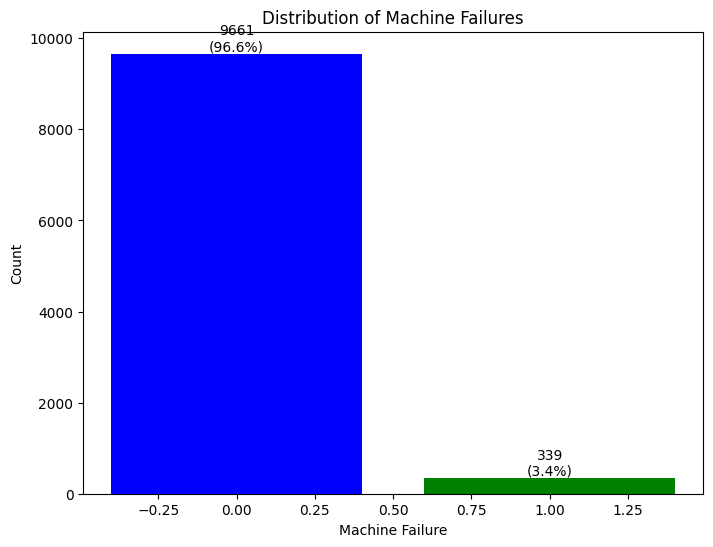

In [ ]:
failure_counts = df['Machine failure'].value_counts()

# Calculer les pourcentages
total_counts = failure_counts.sum()
percentages = (failure_counts / total_counts) * 100

# Créer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.index, failure_counts.values, color=['blue', 'green', 'red', 'purple', 'orange'])

# Ajouter les nombres d'éléments et les pourcentages au-dessus des barres
for bar, count, percentage in zip(bars, failure_counts.values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures')
plt.show()


**ANALYSIS QUESTION:** What do you observe?

We can see a significant imbalance in the data: there are 28.5 times more working machines than failing machines. This reflects the reality of machines operating in a cleanroom environment. However, this imbalance might impact the predictive AI.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

In this case, the AI may learn to predict that a machine is working, as this is the vast majority of the cases. Moreover, it might not be able to learn meaningful patterns in failing machines due to their underrepresentation in the dataset.

We can expect an accuracy of 96.6%, which would indicate that the model always predicts "working machine." In this case, the prediction system would be completely useless because it fails to detect failing machines, rendering it ineffective for its intended purpose.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

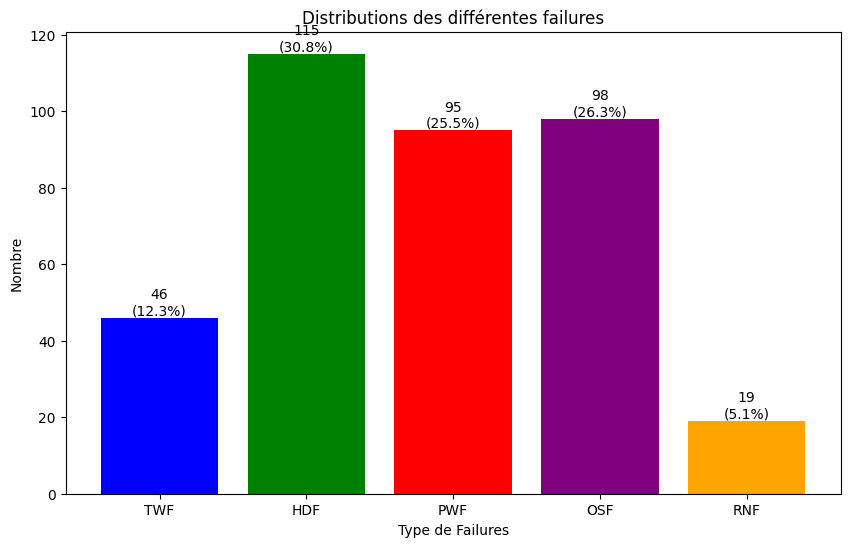

In [ ]:
failure_TWF_counts = df['TWF'].value_counts()
failure_HDF_counts = df['HDF'].value_counts()
failure_PWF_counts = df['PWF'].value_counts()
failure_OSF_counts = df['OSF'].value_counts()
failure_RNF_counts = df['RNF'].value_counts()
fail_tot = [failure_TWF_counts[1], failure_HDF_counts[1], failure_PWF_counts[1], failure_OSF_counts[1], failure_RNF_counts[1]]
labels = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Calculer les pourcentages
total_failures = sum(fail_tot)
percentages = [(count / total_failures) * 100 for count in fail_tot]

# Créer le graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, fail_tot, color=['blue', 'green', 'red', 'purple', 'orange'])

# Ajouter les nombres d'éléments et les pourcentages au-dessus des barres
for bar, count, percentage in zip(bars, fail_tot, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.xlabel('Type de Failures')
plt.ylabel('Nombre')
plt.title('Distributions des différentes failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Even within the distribution of failures, we observe an imbalance: the highest failure class represents 30%, while the lowest accounts for only 5%. This internal imbalance may lead to the same issues as before, with the model being biased toward the most frequent failure types and struggling to learn meaningful patterns for the rarer ones.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

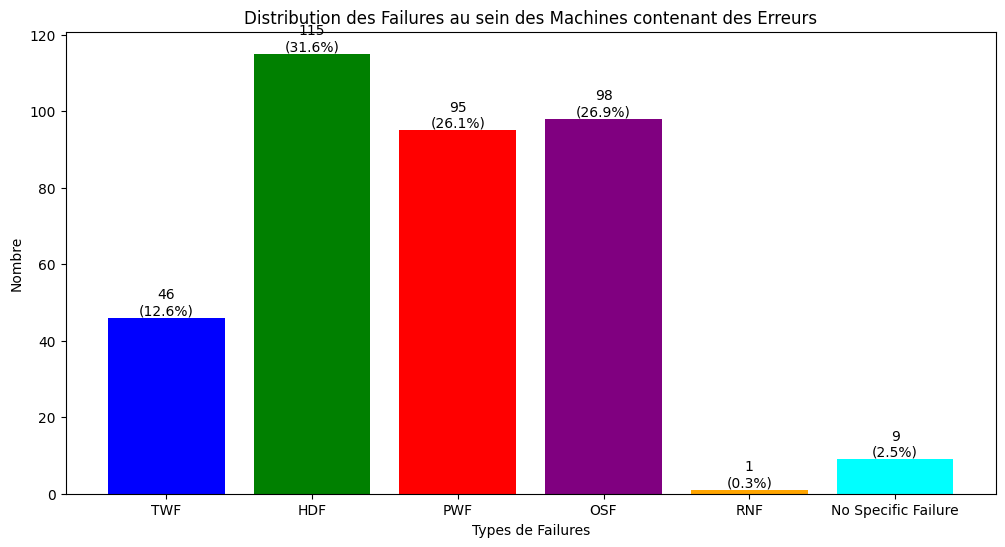

In [ ]:
failed_machines = df[df['Machine failure'] == 1]

failure_type_counts = {
    'TWF': 0,
    'HDF': 0,
    'PWF': 0,
    'OSF': 0,
    'RNF': 0,
    'No Specific Failure': 0
}

for index, row in failed_machines.iterrows():
    failure_found = False
    for failure_type in ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']:
        if row[failure_type] == 1:
            failure_type_counts[failure_type] += 1
            failure_found = True

    if not failure_found:
        failure_type_counts['No Specific Failure'] += 1

labels = list(failure_type_counts.keys())
counts = list(failure_type_counts.values())

# Calculer les pourcentages
total_failures = sum(counts)
percentages = [(count / total_failures) * 100 for count in counts]

# Créer le graphique
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Ajouter les nombres d'éléments et les pourcentages au-dessus des barres
for bar, count, percentage in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.xlabel('Types de Failures')
plt.ylabel('Nombre')
plt.title('Distribution des Failures au sein des Machines contenant des Erreurs')
plt.show()


**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

We observe a difference in the data. This is due to the restriction Machine failure == 1. This suggests that the data may be inconsistent, as it is possible to have a failure type without a machine failure. This brings us closer to a more realistic industrial case, where data processing is necessary.
Comparing this graph with the previous one, we notice that RNF failures show a significant difference. While 19 RNF instances (5.1%) appeared in the general distribution, only 1 instance (0.3%) appears among machines that actually failed. This suggests that random failures rarely lead to complete machine breakdown. The other failure types (TWF, HDF, PWF, OSF) maintain similar relative distributions, with HDF remaining the most common.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

The inputs are all the data that comes from the environment. Those are the data that tell us in what health is the machine. Such datas are: air temperature, process temperature, rotational speed, torque, and tool wear.

Based on these elements, the model predicts the type of failure. The outputs
correspond to the machine failure value as well as the five failure types : TWF,
HDF,PWF,OSF,RNF

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

<ipython-input-196-655de4187456>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_B['Error Class'] = np.where(no_error_condition, 'Pas d erreurs', Y_B.idxmax(axis=1))


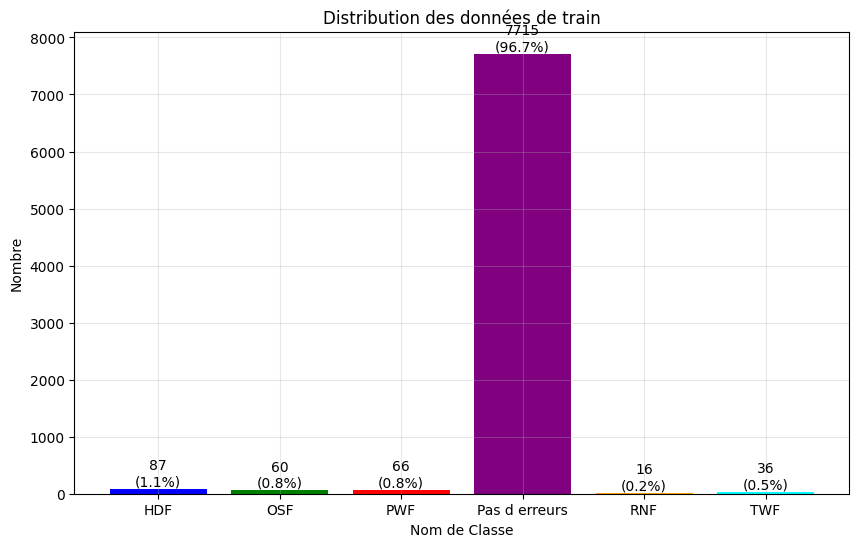

In [ ]:
data_copy = df.copy()
data_copy['sum_columns'] = data_copy[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

# Filtrer les lignes où la somme est supérieure à 1
manyOnes = data_copy[data_copy['sum_columns'] > 1]

# Supprimer ces lignes du DataFrame initial
df = df.drop(manyOnes.index)

X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y_B = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Ajout de la colonne "Error Class"
no_error_condition = (Y_B[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']] == 0).all(axis=1)
Y_B['Error Class'] = np.where(no_error_condition, 'Pas d erreurs', Y_B.idxmax(axis=1))

X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(X, Y_B['Error Class'], test_size=0.2, random_state=42)

# Encodage des étiquettes
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train_B)
Y_test_encoded = label_encoder.transform(Y_test_B)

# Transformation en catégories
Y_train_treated = to_categorical(Y_train_encoded)
Y_test_B = to_categorical(Y_test_encoded)

# Calculer les pourcentages
counts = np.bincount(Y_train_encoded)
total_counts = counts.sum()
percentages = (counts / total_counts) * 100

# Créer le graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(label_encoder.classes_)), counts, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Ajouter les nombres d'éléments et les pourcentages au-dessus des barres
for bar, count, percentage in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.title('Distribution des données de train')
plt.xlabel('Nom de Classe')
plt.ylabel('Nombre')
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_)
plt.grid(alpha=0.3)
plt.show()


**QUESTION** Code below the model architecture

In [ ]:
inputs = tf.keras.Input(shape=(X_train_B.shape[1],))
x = Dense(512, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='tanh')(x)
outputs = Dense(6, activation='softmax')(x)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Model: "my_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_68 (Dense)            (None, 512)               3072      
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)               

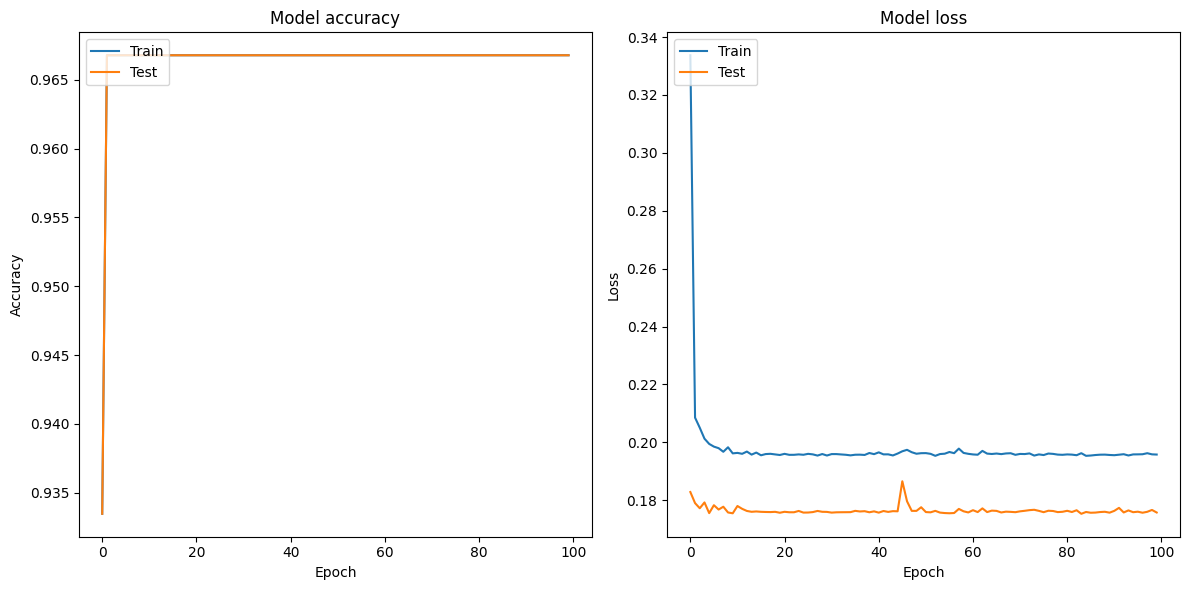

In [ ]:
#PARTIE TRAINING

my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")
my_mlp_model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nb_epochs=70
batch_size=128

training_history = my_mlp_model.fit(X_train_B,Y_train_treated,
                                    validation_data=(X_test_B, Y_test_B),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)



#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train_B, Y_train_treated, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test_B, Y_test_B, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)



##PARTIE AFFICHAGE
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss']) # Assuming you used validation data in model.fit()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


**QUESTION** Plot the confusion matrix and the classification report

1.   Élément de liste
2.   Élément de liste



**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

<ipython-input-199-da4ea878fd49>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_B['Error Class'] = np.where(no_error_condition, 'Pas d erreurs', Y_B.idxmax(axis=1))


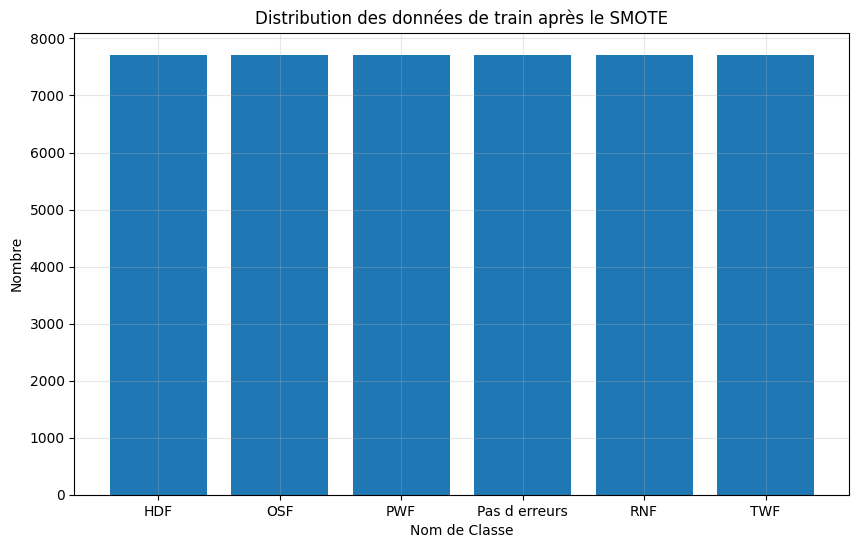

Finale
X_train shape: (46290, 5)
Y_train shape: (46290, 6)
X_test shape: (1996, 5)
Y_test shape: (1996, 6)


In [ ]:
data_copy = df.copy()
data_copy['sum_columns'] = data_copy[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

# Filtrer les lignes où la somme est supérieure à 1
manyOnes = data_copy[data_copy['sum_columns'] > 1]

# Supprimer ces lignes du DataFrame initial
df = df.drop(manyOnes.index)

X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y_B = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Ajout de la colonne "Error Class"
no_error_condition = (Y_B[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']] == 0).all(axis=1)
Y_B['Error Class'] = np.where(no_error_condition, 'Pas d erreurs', Y_B.idxmax(axis=1))

X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(X, Y_B['Error Class'], test_size=0.2, random_state=42)

# Encodage des étiquettes
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train_B)
Y_test_encoded = label_encoder.transform(Y_test_B)

# Application de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train_B, Y_train_encoded)

# Affichage de la répartition des données après le SMOTE
plt.figure(figsize=(10, 6))
plt.bar(range(len(label_encoder.classes_)), np.bincount(y_train_smoted))
plt.title('Distribution des données de train après le SMOTE')
plt.xlabel('Nom de Classe')
plt.ylabel('Nombre')
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_)
plt.grid(alpha=0.3)
plt.show()

# Application de l'undersampling
min_vise = min(Counter(y_train_smoted).values())
strat = {classe: min_vise for classe in set(y_train_smoted)}
undersampling = RandomUnderSampler(sampling_strategy=strat, random_state=42)
X_train_treated, Y_train_treated = undersampling.fit_resample(X_train_smoted, y_train_smoted)

# Transformation en catégories
Y_train_treated = to_categorical(Y_train_treated)
Y_test_B = to_categorical(Y_test_encoded)

# Affichage des tailles
print("Finale")
print("X_train shape:", np.shape(X_train_treated))
print("Y_train shape:", np.shape(Y_train_treated))
print("X_test shape:", np.shape(X_test_B))
print("Y_test shape:", np.shape(Y_test_B))


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

To address the class imbalance in our dataset, we used both SMOTE (Synthetic Minority Over-sampling Technique) and undersampling. SMOTE artificially generates new examples for minority classes, helping the model better learn their characteristics. However, if we only add synthetic data, the majority class remains dominant, which can still bias the model. That’s why we also applied undersampling, which reduces the number of examples in the majority class to create a more balanced dataset. By combining these two techniques, we obtain a more homogeneous dataset

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
inputs = tf.keras.Input(shape=(X_train_treated.shape[1],))
x = Dense(512, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='tanh')(x)
outputs = Dense(6, activation='softmax')(x)

**QUESTION** Code below the algorithms allowing to train model


In [204]:
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")
my_mlp_model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nb_epochs=100
batch_size=128

training_history = my_mlp_model.fit(X_train_treated,Y_train_treated,
                                    validation_data=(X_test_B, Y_test_B),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

loss_train, acc_train = my_mlp_model.evaluate(X_train_treated, Y_train_treated, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test_B, Y_test_B, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_73 (Dense)            (None, 512)               3072      
                                                                 
 dense_74 (Dense)            (None, 128)               65664     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 32)                4128      
                                                                 
 dense_76 (Dense)            (None, 6)                 198       
                                                                 
Total params: 73,062
Trainable params: 73,062
Non-trai

**QUESTION** Plot the confusion matrix and the classification report

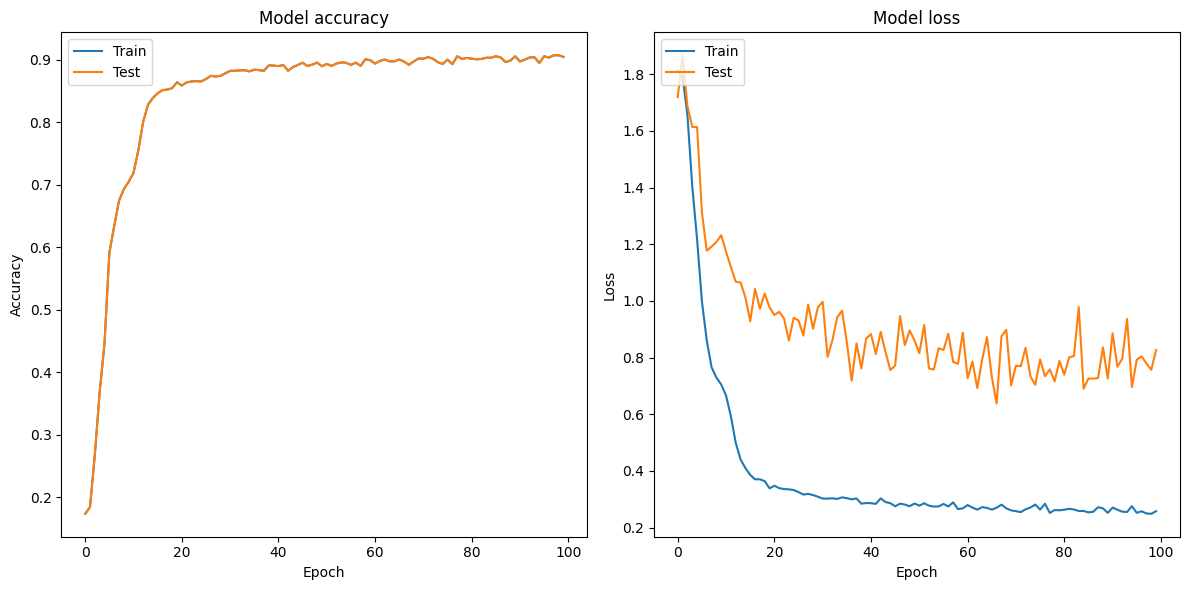

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss']) # Assuming you used validation data in model.fit()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

In [ ]:
np.save("x_test_premier.npy",X_test_B)
np.save("y_test_premier.npy",Y_test_B)

import tensorflow as tf

tf.keras.models.save_model(my_mlp_model, "Model_Premier.h5")  # Save the model before loading it

# Charger le modèle Keras (.h5)
my_mlp_model = tf.keras.models.load_model("Model_Premier.h5")

# Convertir en TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(my_mlp_model)
tflite_model = converter.convert()

# Sauvegarder en fichier .tflite
with open("Model_Premier.tflite", "wb") as f:
    f.write(tflite_model)

print("Conversion réussie : Model_Premier.tflite enregistré !")

Conversion réussie : Model_Premier.tflite enregistré !
